In [1]:
import torch
import os
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(torch.cuda.is_available(), "|", torch.cuda.get_device_name(0))

True | GeForce RTX 3060 Ti


## Loading the Data

In [3]:
from PIL import Image
# Creating my own Dataset class for loading the images properly into PyTorch
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [4]:
import pickle
# The dataset is downloaded from the Tensorflow example: 
# (https://github.com/nutte2/DeepRL/blob/master/Traffic_Sign_Classifier.ipynb)
# Using the following link for download: 
# 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip'
# This was done because the "GTSRB_Final_Test_Images.zip" was lacking correct labelling. 
# Later I did find out you can download "GTSRB_Final_Test_GT.zip" to get proper labels,
# but this seems to work fine aswell.  
training_file = 'traffic_signs_data/train.p'
validation_file= 'traffic_signs_data/valid.p'
testing_file = 'traffic_signs_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

transform = transforms.Compose([
                transforms.Resize((32, 32)),
                #transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()
            ])

train_set = MyDataset(X_train, y_train, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = MyDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_set, batch_size=64)

### Extracting the stop signs

In [21]:
stop_X_test = []
stop_y_test = []

for y in range(len(y_test)):
    if y_test[y] == 14:
        stop_y_test.append(14)
        stop_X_test.append(X_test[y])

print("Number of stop-signs: ", len(stop_X_test))
        
stop_test_set = MyDataset(stop_X_test, stop_y_test, transform=transform)
stop_test_loader = DataLoader(stop_test_set, batch_size=len(stop_X_test))

<class 'list'>
Number of stop-signs:  270


## Defining the model

In [6]:
model = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Flatten(),
                          nn.Linear(4096, 100), nn.ReLU(),
                          nn.Linear(100, 44)).to(device)

## Training the network

In [153]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [154]:
opt = optim.SGD(model.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.812696	2.911105	0.609660	1.906533
0.302049	0.918929	0.207680	0.832302
0.064628	0.216997	0.143785	0.565573
0.024685	0.085341	0.120190	0.573072
0.012328	0.042003	0.117577	0.599549
0.009541	0.032926	0.108868	0.641566
0.004512	0.015415	0.108630	0.674896
0.003190	0.012936	0.102692	0.719556
0.003017	0.011819	0.106968	0.697908
0.002443	0.008268	0.098971	0.692938


In [155]:
torch.save(model.state_dict(), "model_1.pt")

In [7]:
model.load_state_dict(torch.load("model_1.pt"))

<All keys matched successfully>

## Final accuracy of the model on the test-set 

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 90 %


### Remove stop-signs that were predicted wrong by model

In [35]:
# STOP sign = classid 14 

# Get predictions for stop signs
for X,y in stop_test_loader:
    X,y = X.to(device), y.to(device)
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)
    break

# Remove wrong predictions
i = 0 
for p in predicted:
    if p != 14:
        stop_X_test.pop(i)
        stop_y_test.pop(i)
    i += 1


print("Number of correctly predicted stop-signs : ", len(stop_X_test))
        
stop_test_set = MyDataset(stop_X_test, stop_y_test, transform=transform)
stop_test_loader = DataLoader(stop_test_set, batch_size=len(stop_X_test))
    
# Reload the batch of correctly predicted stop signs
for X,y in stop_test_loader:
    X,y = X.to(device), y.to(device)
    break

Number of correctly predicted stop-signs :  253


## Fast Gradient Sign Method

In [36]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [37]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

### Attacked Images

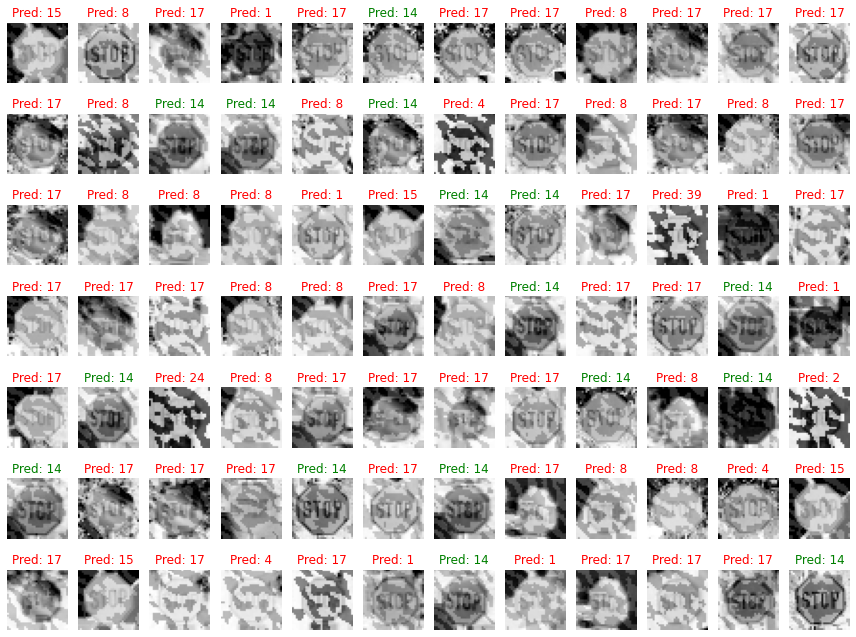

In [38]:
model.to(device)
delta = fgsm(model, X, y, 0.1)
yp = model(X + delta)
plot_images(X+delta, y, yp, 7, 12)

### Normal Images

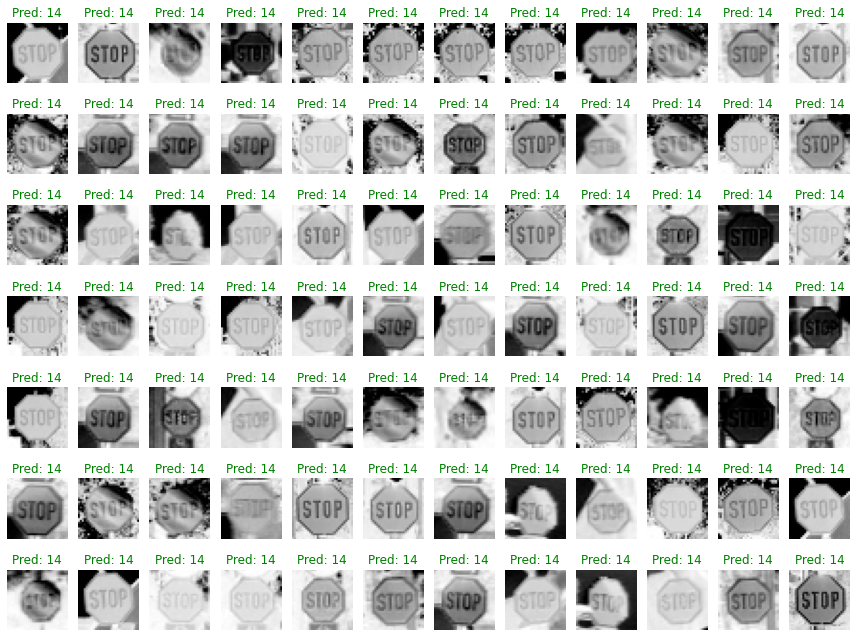

In [39]:
yp = model(X)
plot_images(X, y, yp, 7, 12)

In [44]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

print("Test Error: ", epoch_adversarial(model, stop_test_loader, fgsm, 0.1)[0])

Test Error:  0.83399209486166


## Untargeted Projected Gradient Descent

In [41]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

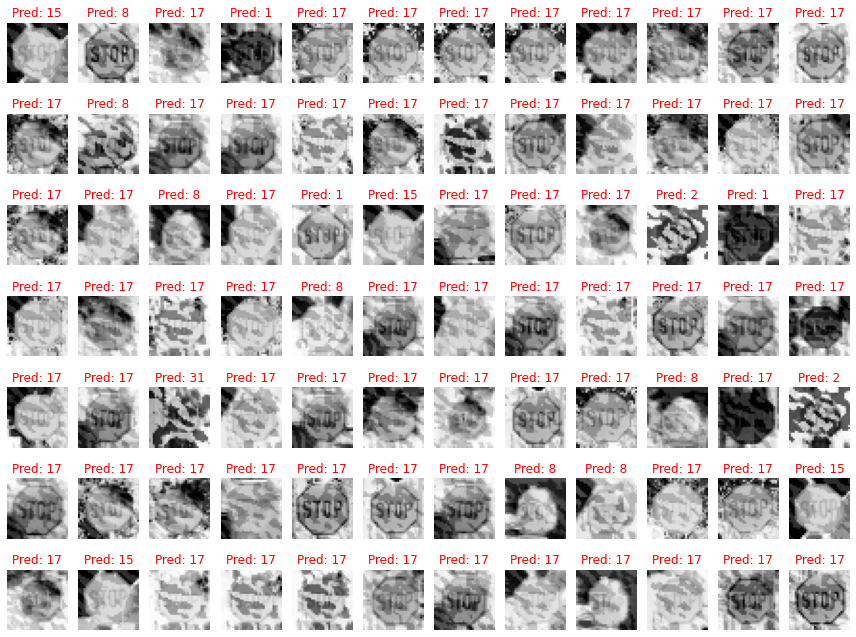

In [42]:
delta = pgd_linf(model, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model(X + delta)
plot_images(X+delta, y, yp, 7, 12)

In [45]:
print("Test Error: ", epoch_adversarial(model, stop_test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

Test Error:  1.0


## Targeted Projected Gradient Descent

In [46]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

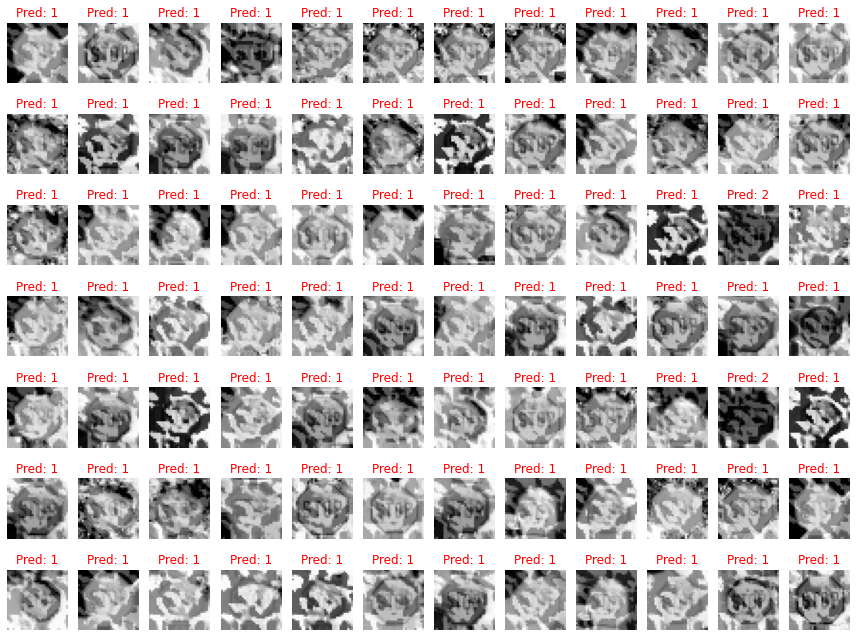

In [47]:
delta = pgd_linf_targ(model, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=1)
yp = model(X + delta)
plot_images(X+delta, y, yp, 7, 12)

In [48]:
print("Test Error: ", epoch_adversarial(model, stop_test_loader, pgd_linf_targ, 0.2, 1e-2, 40, 1)[0])

Test Error:  1.0


## Targeted Projected Gradient Descent 2

In [49]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

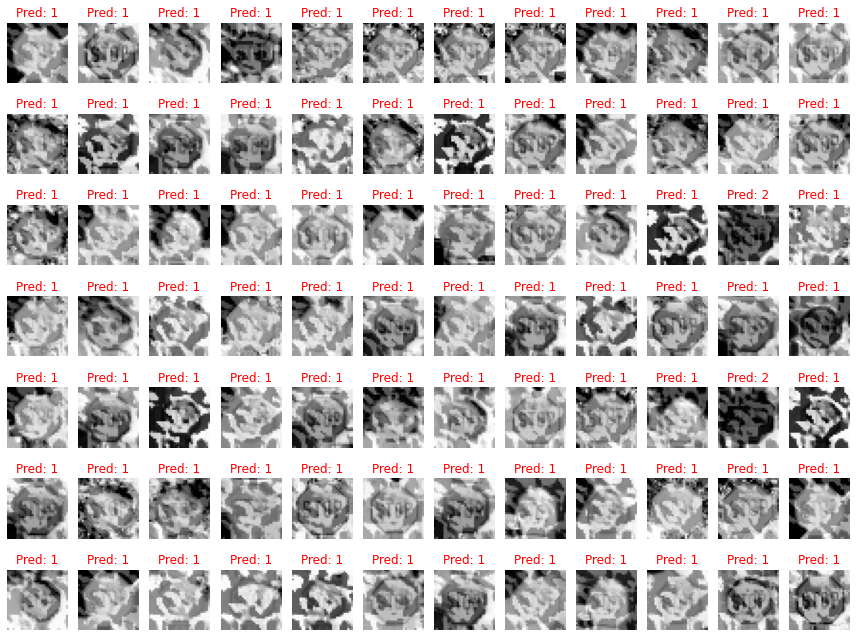

In [50]:
delta = pgd_linf_targ(model, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=1)
yp = model(X + delta)
plot_images(X+delta, y, yp, 7, 12)

In [51]:
print("Test Error: ", epoch_adversarial(model, stop_test_loader, pgd_linf_targ2, 2, 0.1, 40, 1)[0])

Test Error:  1.0
